# Testing time marching in package `Whirl`

In [1]:
include(joinpath(Pkg.dir("Whirl"), "src/Whirl.jl"))
using Whirl

In [2]:
using Plots
#pyplot()
#clibrary(:colorbrewer)
#default(grid = false)

### Basic unconstrained system

First, we will solve a basic system

$\frac{\displaystyle du}{\displaystyle dt} = \cos(\omega t)$

with $u(0) = u_0$. The exact solution is

$u(t) = u_0 + \frac{\displaystyle 1}{\displaystyle \omega}\sin(\omega t)$

In [3]:
ω = 4
u₀ = 1.0
uex(t) = u₀ + sin(ω*t)/ω

uex (generic function with 1 method)

In [4]:
Δt = 0.005
T = 0:Δt:10
u = [u₀]
TimeMarching.r₁(u::Vector{Float64},t::Float64) = cos(ω*t)
rk = RK(u,Δt,r₁,rk=TimeMarching.RK31)

Order-3 RK integator with
   State of type Array{Float64,1}
   Time step size 0.005


In [5]:
u = [u₀]
uhist = Float64[]
for t in T
    push!(uhist,u[1])
    t,u = rk(t,u)
end

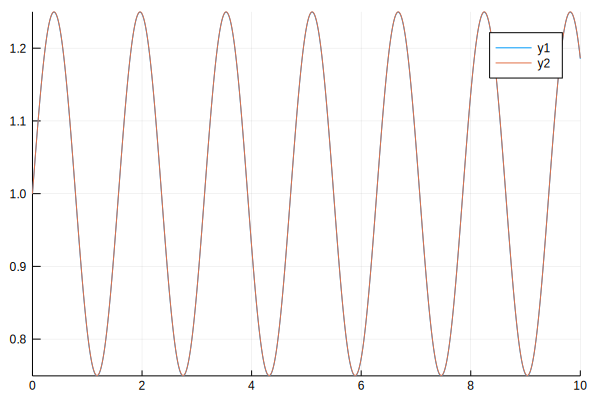

In [6]:
plot(T,uhist)
plot!(T,uex.(T))

### Unconstrained system with integrating factor

Next, we will solve an unconstrained system with an integrating factor

$\frac{\displaystyle du}{\displaystyle dt} = -\alpha u + \cos(\omega t)$

with $u(0) = u_0$. The exact solution is

$u(t) = u_0 e^{-\alpha t} + \frac{\displaystyle 1}{\displaystyle \alpha^2+\omega^2}\left(\alpha(\cos(\omega t)-e^{-\alpha t})+\omega \sin(\omega t)\right) $

In [7]:
α = 0.5
ω = 4
u₀ = 1.0
uex(t) = u₀*exp(-α*t) + (α*(cos(ω*t)-exp(-α*t))+ω*sin(ω*t))/(α^2+ω^2)

uex (generic function with 1 method)

Set up the integrating factor constructor

In [8]:
Whirl.plan_intfact(t::Float64,u::Vector{Float64}) = exp(-α*t)

In [9]:
Δt = 0.005
T = 0:Δt:10
u = [u₀]
TimeMarching.r₁(u::Vector{Float64},t::Float64) = cos(ω*t)
ifrk = IFRK(u,Δt,plan_intfact,r₁,rk=TimeMarching.RK31)

Order-3 IF-RK integator with
   State of type Array{Float64,1}
   Time step size 0.005


In [11]:
u = [u₀]
uhist = Float64[]
for t in T
    push!(uhist,u[1])
    t,u = ifrk(t,u)
end

In [12]:
norm(uhist-uex.(T))

0.01806544831164993

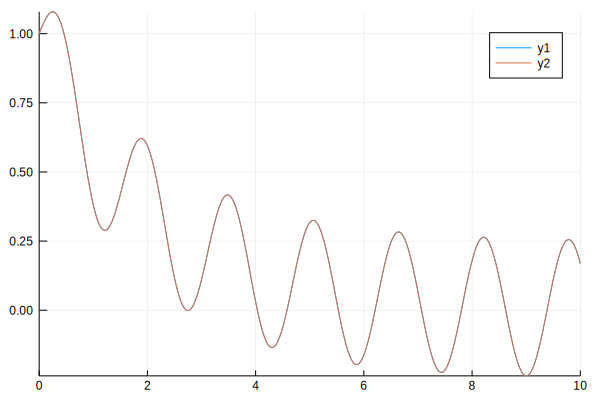

In [13]:
plot(T,uhist)
plot!(T,uex.(T))

### Constrained system with integrating factor

Now let's do a more interesting example: 2-d diffusion from a circle

In [34]:
nx = 129; ny = 129;
Lx = 2.0;
dx = Lx/(nx-2);
w = Nodes(Dual,(nx,ny));

In [35]:
n = 128;
θ = linspace(0,2π,n+1);
R = 0.5;
xb = 1.0 + R*cos.(θ[1:n])
yb = 1.0 + R*sin.(θ[1:n])
ds = (2π/n)*R;
X = VectorData(xb,yb);
f = ScalarData(X);

In [36]:
E = Regularize(X,dx;ddftype=Fields.Roma,issymmetric=true)
Hmat, Emat = RegularizationMatrix(E,f,w);

In [37]:
TimeMarching.r₁(w::Nodes{T,NX,NY},t::Float64) where {T,NX,NY} = Nodes(T,w)
TimeMarching.r₂(w::Nodes{T,NX,NY},t::Float64) where {T,NX,NY} = 1.0

In [38]:
Δt = 1.0
ifherk = IFHERK(w,f,Δt,plan_intfact,(Hmat,Emat),(r₁,r₂),rk=TimeMarching.Euler)

Order-1 IF-HERK integrator with
   State of type Whirl.Fields.Nodes{Whirl.Fields.Dual,129,129}
   Force of type Whirl.Fields.ScalarData{128}
   Time step size 1.0


In [17]:
@time ifherk.S[1].B₂A⁻¹(w)
@time ifherk.S[1].S*f;
@time ifherk.S[1].A⁻¹B₁ᵀ(f);

  0.011576 seconds (43 allocations: 161.750 KiB)
  0.007730 seconds (31 allocations: 320.047 KiB)
  0.010680 seconds (43 allocations: 289.609 KiB)


In [39]:
@time ifherk(0.0,w)

  0.032258 seconds (103 allocations: 1.137 MiB)


(1.0, Whirl.Fields.Dual nodes in a (nx = 129, ny = 129) cell grid
  Number of Whirl.Fields.Dual nodes: (nx = 129, ny = 129), 128 points of scalar-valued data
)

In [20]:
t = 0.0
w = Nodes(Dual,(nx,ny));

In [21]:
@time for i = 1:20
    t,w,f = ifherk(t,w);
end

  0.996163 seconds (3.86 k allocations: 35.851 MiB, 2.06% gc time)


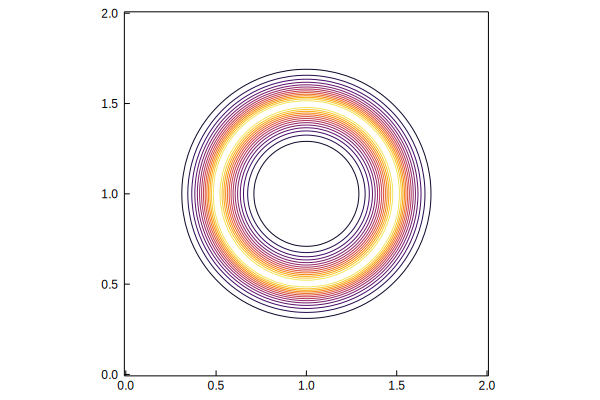

In [22]:
xg, yg = coordinates(w,dx=dx)
plot(xg,yg,w)

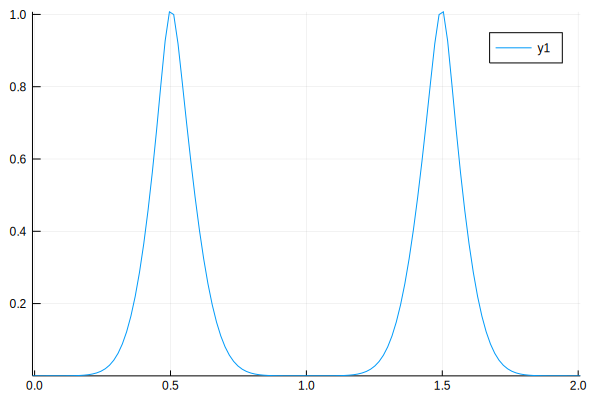

In [23]:
plot(xg,w[65,:])

### Solving basic unconstrained system with IFHERK

In [22]:
ω = 4
u₀ = 1.0
uex(t) = u₀ + sin(ω*t)/ω

uex (generic function with 1 method)

In [23]:
Δt = 0.005
T = 0:Δt:10
u = [u₀]
f = Vector{Float64}()
TimeMarching.r₁(u::Vector{Float64},t::Float64) = cos(ω*t)
TimeMarching.r₂(u::Vector{Float64},t::Float64) = Vector{Float64}()
TimeMarching.B₁ᵀ(f::Vector{Float64}) = zeros(Float64,1)
TimeMarching.B₂(u::Vector{Float64}) = Vector{Float64}()
Fields.plan_intfact(t::Float64,u::Vector{Float64}) = eye(1)
ifherk = IFHERK(u,f,Δt,plan_intfact,(B₁ᵀ,B₂),(r₁,r₂),rk=TimeMarching.RK31)

Order-3 IF-HERK integrator with
   State of type Array{Float64,1}
   Force of type Array{Float64,1}
   Time step size 0.005


In [26]:
u = [u₀]
uhist = Float64[]
for t in T
    push!(uhist,u[1])
    t,u,_ = ifherk(t,u)
end

In [27]:
norm(uhist-uex.(T))

0.02851937665557481

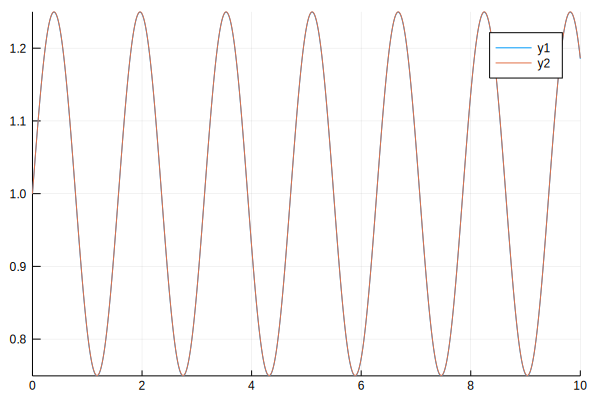

In [28]:
plot(T,uhist)
plot!(T,uex.(T))

### Advancing a combination of non-integrating factor systems

In [2]:
ω₁ = 4
u₀ = 1.0
uex(t) = u₀ + sin(ω₁*t)/ω₁

uex (generic function with 1 method)

In [3]:
ω₂ = 2
v₀ = 0.5
vex(t) = v₀ + sin(ω₂*t)/ω₂

vex (generic function with 1 method)

Note that r₁ receives the full tuple of states and returns a tuple

In [6]:
Δt = 0.005
T = 0:Δt:10
u = ([u₀],[v₀])
TimeMarching.r₁(u::Tuple{Vector{Float64},Vector{Float64}},t::Float64) =  ([cos(ω₁*t)], [cos(ω₂*t)])
rk = RK(u,Δt,TimeMarching.r₁,rk=TimeMarching.RK31)

Order-3 RK integator with
   State of type Tuple{Array{Float64,1},Array{Float64,1}}
   Time step size 0.005


In [7]:
u = ([u₀],[v₀])
u₁hist = Float64[]
u₂hist = Float64[]
for t in T
    push!(u₁hist,u[1][1])
    push!(u₂hist,u[2][1])
    t,u = rk(t,u)
end

In [13]:
println("error for first element of tuple = ",norm(u₁hist-uex.(T)))
println("error for second element of tuple = ",norm(u₂hist-vex.(T)))

error for first element of tuple = 0.02851937665557481
error for second element of tuple = 0.02813561410675741


### Advancing a combination of integrating factor systems

In [11]:
α₁ = 0.5
ω₁ = 4
u₀ = 1.0
uex(t) = u₀*exp(-α₁*t) + (α₁*(cos(ω₁*t)-exp(-α₁*t))+ω₁*sin(ω₁*t))/(α₁^2+ω₁^2)

uex (generic function with 1 method)

In [12]:
α₂ = 0.5
ω₂ = 2
v₀ = 0.5
vex(t) = v₀*exp(-α₂*t) + (α₂*(cos(ω₂*t)-exp(-α₂*t))+ω₂*sin(ω₂*t))/(α₂^2+ω₂^2)

vex (generic function with 1 method)

In [13]:
u = ([u₀],[v₀])

([1.0], [0.5])

Set up the integrating factor constructor

In [16]:
plan1_intfact(t::Float64,u::Vector{Float64}) = exp(-α₁*t)
plan2_intfact(t::Float64,u::Vector{Float64}) = exp(-α₂*t)

plan2_intfact (generic function with 1 method)

In [17]:
Δt = 0.005
T = 0:Δt:10
u = ([u₀],[v₀])
TimeMarching.r₁(u::Tuple{Vector{Float64},Vector{Float64}},t::Float64) = ([cos(ω₁*t)], [cos(ω₂*t)])
ifrk = IFRK(u,Δt,(plan1_intfact,plan2_intfact),TimeMarching.r₁,rk=TimeMarching.RK31)

Order-3 IF-RK integator with
   State of type Tuple{Array{Float64,1},Array{Float64,1}}
   Time step size 0.005


In [18]:
u = ([u₀],[v₀])
u₁hist = Float64[]
u₂hist = Float64[]
for t in T
    push!(u₁hist,u[1][1])
    push!(u₂hist,u[2][1])
    t,u = ifrk(t,u)
end

In [19]:
println("error for first element of tuple = ",norm(u₁hist-uex.(T)))
println("error for second element of tuple = ",norm(u₂hist-vex.(T)))

error for first element of tuple = 0.01806544831164993
error for second element of tuple = 0.017682930356779633


### Advancing a combination of constrained integrating factor system and basic system

In [41]:
nx = 129; ny = 129;
Lx = 2.0;
dx = Lx/(nx-2);
w = Nodes(Dual,(nx,ny));

In [42]:
n = 128;
θ = linspace(0,2π,n+1);
R = 0.5;
xb = 1.0 + R*cos.(θ[1:n])
yb = 1.0 + R*sin.(θ[1:n])
ds = (2π/n)*R;
X = VectorData(xb,yb);
f1 = ScalarData(X);

In [43]:
ω₁ = 4
u₀ = 1.0
uex(t) = u₀ + sin(ω₁*t)/ω₁

uex (generic function with 1 method)

Set up the state vector tuple and force tuple

In [44]:
u = (w,[u₀])
f = (f1,Vector{Float64}())
TU = typeof(u)
TF = typeof(f)

Tuple{Whirl.Fields.ScalarData{128},Array{Float64,1}}

In [45]:
E = Regularize(X,dx;issymmetric=true)
Hmat, Emat = RegularizationMatrix(E,f1,w);

Set up the operators

In [46]:
TimeMarching.r₁(u::TU,t::Float64) = (Nodes(Dual,w),[cos(ω₁*t)])
TimeMarching.r₂(u::TU,t::Float64) = (ScalarData(ones(length(f1))),Vector{Float64}())
B₁ᵀ2(f::Vector{Float64}) = zeros(Float64,1)
B₂2(u::Vector{Float64}) = Vector{Float64}()
B₁ᵀlist = (Hmat,B₁ᵀ2)
B₂list = (Emat,B₂2)
plans = (Fields.plan_intfact,(t,u) -> eye(1))

(Whirl.Fields.plan_intfact, #5)

In [47]:
Δt = 0.01
ifherk = IFHERK(u,f,Δt,plans,(B₁ᵀlist,B₂list),(TimeMarching.r₁,TimeMarching.r₂),rk=TimeMarching.Euler)

Order-1 IF-HERK integrator with
   State of type Tuple{Whirl.Fields.Nodes{Whirl.Fields.Dual,129,129},Array{Float64,1}}
   Force of type Tuple{Whirl.Fields.ScalarData{128},Array{Float64,1}}
   Time step size 0.01


In [50]:
@time ifherk(0.0,u)

  37.261 ms (192 allocations: 1.45 MiB)


(0.01, (Whirl.Fields.Dual nodes in a (nx = 129, ny = 129) cell grid
  Number of Whirl.Fields.Dual nodes: (nx = 129, ny = 129), [3.68785]), (128 points of scalar-valued data
, Float64[]))